# Linear Regression
****

We already know that a linear regression will not be a suitable model since our primary goal is to find a way to accurately identify the logerror clusters at $\pm 2$. However, we will still use a linear regression model to gain some insights into the data.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math
import scipy.stats as stats
import sklearn

# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.display import display, HTML
#display(HTML("<style>.rendered_html{font-size: 18px; line-height: 1.4}</style>"))

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
Housing_data = pd.read_csv('cleaned_1.csv')
print(Housing_data.info())
Housing_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167854 entries, 0 to 167853
Data columns (total 45 columns):
Unnamed: 0                      167854 non-null int64
parcelid                        167854 non-null int64
airconditioningtypeid           167854 non-null float64
bathroomcnt                     167854 non-null float64
bedroomcnt                      167854 non-null float64
buildingqualitytypeid           167854 non-null float64
calculatedfinishedsquarefeet    166992 non-null float64
fips                            167854 non-null float64
fireplacecnt                    167854 non-null float64
garagecarcnt                    167854 non-null float64
garagetotalsqft                 167854 non-null float64
hashottuborspa                  167854 non-null float64
heatingorsystemtypeid           167854 non-null float64
latitude                        167854 non-null float64
longitude                       167854 non-null float64
lotsizesquarefeet               167854 non-null float

,Unnamed: 0,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,...,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,LivingAreaProp,ExtraSpace,PropUseType,tax_avg,tax_deviation
0,0,17073783,1.0,2.5,3.0,0.0,1264.0,6111.0,0.0,2.0,...,76724.0,2015.06,6.111002e+13,0.0953,2016-01-27,0.728530,471.0,3.0,158582.578125,0.274277
1,1,17088994,1.0,1.0,2.0,0.0,777.0,6111.0,0.0,1.0,...,95870.0,2581.30,6.111002e+13,0.0198,2016-03-30,0.205556,3003.0,3.0,158582.578125,0.093160
2,2,17100444,1.0,2.0,3.0,0.0,1101.0,6111.0,0.0,2.0,...,14234.0,591.64,6.111001e+13,0.0060,2016-05-27,0.167605,5468.0,3.0,130160.945312,0.741712
3,3,17102429,1.0,1.5,2.0,0.0,1554.0,6111.0,1.0,2.0,...,17305.0,682.78,6.111001e+13,-0.0566,2016-06-07,0.210000,5846.0,3.0,130160.945312,0.649595
4,4,17109604,1.0,2.5,4.0,0.0,2415.0,6111.0,1.0,2.0,...,277000.0,5886.92,6.111002e+13,0.0573,2016-08-08,0.381758,3911.0,3.0,158582.578125,0.746724


In [3]:
Housing_data = Housing_data.set_index(['parcelid','Unnamed: 0'])
#del Housing_data['garagetotalsqft'] # this has a very large amount of missing data, so will be excluded for now
Housing_data['transactiondate'] = pd.to_datetime(Housing_data['transactiondate'], 
                                                 format = '%Y-%m-%d', errors = 'coerce')
#Housing_data['yearbuilt'] = pd.to_datetime(Housing_data['yearbuilt'], format='%Y.0', errors='coerce').dt.year
#Housing_data['assessmentyear'] = pd.to_datetime(Housing_data['assessmentyear'], 
                                                #format='%Y-%m-%d', errors='coerce').dt.year
#Housing_data['taxdelinquencyyear'] = pd.to_datetime(Housing_data['taxdelinquencyyear'], 
                                                    #format='%Y-%m-%d', errors='coerce').dt.year

#House_df = Housing_data.drop(['taxdelinquencyyear'], axis = 1)
House_df = Housing_data.dropna()
#House_df['yearbuiltint'] = House_df['yearbuilt'].astype(int)
House_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 166355 entries, (17073783, 0) to (14360869, 77575)
Data columns (total 43 columns):
airconditioningtypeid           166355 non-null float64
bathroomcnt                     166355 non-null float64
bedroomcnt                      166355 non-null float64
buildingqualitytypeid           166355 non-null float64
calculatedfinishedsquarefeet    166355 non-null float64
fips                            166355 non-null float64
fireplacecnt                    166355 non-null float64
garagecarcnt                    166355 non-null float64
garagetotalsqft                 166355 non-null float64
hashottuborspa                  166355 non-null float64
heatingorsystemtypeid           166355 non-null float64
latitude                        166355 non-null float64
longitude                       166355 non-null float64
lotsizesquarefeet               166355 non-null float64
poolcnt                         166355 non-null float64
poolsizesum               

In earlier notebooks we identified a number of features which we showed a connection to the logerror clusters. However, right away we see a major problem with using these features for linear regression. Below are a few plots of some of these features. The rest can be found in the Visualizations notebook.

Text(0.5,0,'regionidcity')

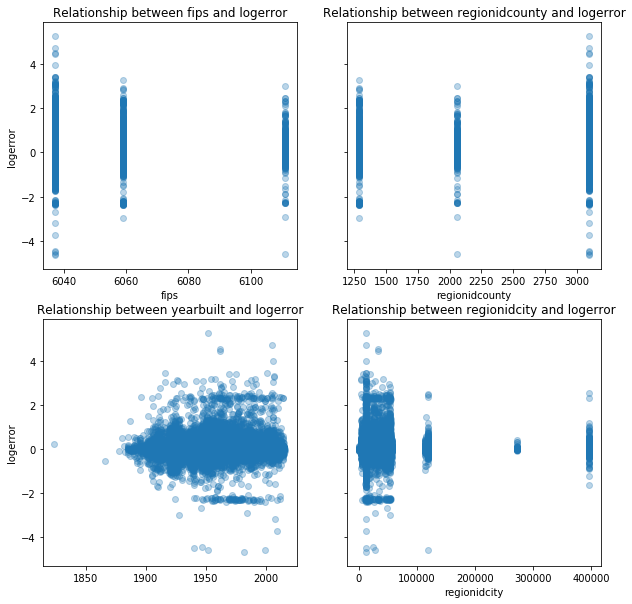

In [4]:
# Two subplots, unpack the axes array immediately
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True, figsize = (10,10))
ax1.set_ylabel("logerror")
ax1.scatter(House_df['fips'], House_df['logerror'], alpha = 0.3)
ax1.set_title("Relationship between fips and logerror")
ax1.set_xlabel("fips")
ax2.scatter(House_df['regionidcounty'], House_df['logerror'], alpha = 0.3)
ax2.set_title("Relationship between regionidcounty and logerror")
ax2.set_xlabel("regionidcounty")
ax3.set_ylabel("logerror")
ax3.scatter(House_df['yearbuilt'], House_df['logerror'], alpha = 0.3)
ax3.set_title("Relationship between yearbuilt and logerror")
ax4.set_xlabel("yearbuilt")
ax4.scatter(House_df['regionidcity'], House_df['logerror'], alpha = 0.3)
ax4.set_title("Relationship between regionidcity and logerror")
ax4.set_xlabel("regionidcity")

In the notebook Visualizations we look at several other features to arrive at the following list of features which aid in indentifying the clusers (like yearbuilt and regionidcity above).

In [7]:
cols_for_lin = ['yearbuilt', 'latitude', 'longitude', 'propertycountylandusecode', 
               'propertyzoningdesc', 'bathroomcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt',
               'taxvaluedollarcnt', 'taxamount']
linstr = ('logerror ~ yearbuilt + latitude + longitude + propertycountylandusecode + '
          'propertyzoningdesc + bathroomcnt + taxamount + landtaxvaluedollarcnt + '
          'structuretaxvaluedollarcnt + taxvaluedollarcnt'
         )
print(linstr)

logerror ~ yearbuilt + latitude + longitude + propertycountylandusecode + propertyzoningdesc + bathroomcnt + taxamount + landtaxvaluedollarcnt + structuretaxvaluedollarcnt + taxvaluedollarcnt


As we see below and as we predicted, the linear regression is quite poor, but we have some information that we can use to find a better model.

In particular, the $R^2$ value is exceedingly low so the model accounted for almost none of the errors observed. Additionally, we have a VERY low $F$-statistic, thought the associated $p$ value is also very low, so we can be assured that the coefficients are not zero.

In [8]:
m_house = ols(linstr,House_df).fit()
print(m_house.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     37.54
Date:                Mon, 10 Sep 2018   Prob (F-statistic):           2.01e-74
Time:                        02:53:54   Log-Likelihood:                 65318.
No. Observations:              166355   AIC:                        -1.306e+05
Df Residuals:                  166344   BIC:                        -1.305e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

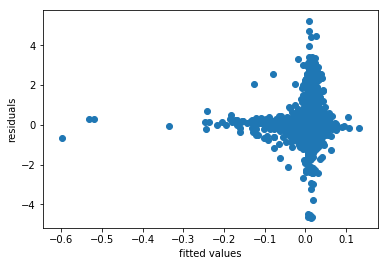

In [9]:
plt.figure()
plt.xlabel("fitted values")
plt.ylabel("residuals")
plt.scatter(m_house.fittedvalues,m_house.resid)

Here we note a very distinctive $+$ shapped plot indicating that we have a non-linear relationship between features and logerror. Confirming that we need something other than a linear regression.

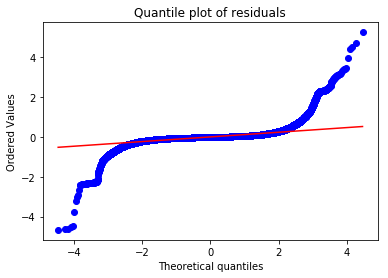

In [10]:
import pylab
plt.figure()
stats.probplot(m_house.resid, dist="norm", plot=pylab)
pylab.title("Quantile plot of residuals")
pylab.show()

So, this plot tells us our data has more extreme data values than a normal distribution.

Finally we will load up a sklearn linear regression in order to evaulate its accuracy as a final test.

In [11]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(House_df[cols_for_lin], House_df['logerror'],# test_size = 0.5,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [-1.30236142e-05  4.08135707e-09  3.42730822e-09 -1.33799474e-05
 -2.91999473e-06  4.95823380e-03 -9.53958819e-08 -8.46491041e-08
  1.28610347e-07 -3.42250019e-06]
linear model intercept (b): 0.300
R-squared score (training): 0.002
R-squared score (test): 0.002


## Polynomial Regression
****
Now we will try to fit with a polynomial regression. First we will try to find the best degree for the polynomial. We will fit a polynomial LinearRegression model on the training data `X_train` for degrees 0 through 9. For each model we compute the $R^2$ (coefficient of determination) regression score on the training data as well as the the test data.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
degree_range = [1,3,6,9]

# This fucntion does the polynomial transformation alone and spits out an array of transformed
# data for each degree. It is kept seperate in case I dont want to transform every time I fit.
# For now, it is not being used.

def build_transforms(degrees): 
    transformed_train = []
    for i in degrees:
        X_train_poly = PolynomialFeatures(degree=i).fit_transform(X_train)
        transformed_train.append(X_train_poly)

    transformed_test = []
    for i in degrees:
        X_test_poly = PolynomialFeatures(degree=i).fit_transform(X_test)
        transformed_test.append(X_test_poly)
        
    return transformed_train, transformed_test

#transformed_train, transformed_test = build_transforms(degree_range)

In [14]:
from sklearn.metrics.regression import r2_score


def r2train_full(i): # this function transforms and fits
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    linreg = LinearRegression().fit(X_train_poly, y_train)
        
    r2_train = linreg.score(X_train_poly, y_train)
    return r2_train

def r2train(i): # in case the transforming func is used, apply this func (not currently being used.)
    linreg = LinearRegression().fit(transformed_train[i], y_train)
        
    r2_train = linreg.score(transformed_train[i], y_train)
    return r2_train

r2_train_list = []
for i in degree_range:
    r2_train_list.append(r2train_full(i))
    #r2_train_list.append(r2train(i))
    
r2_train = np.array(r2_train_list)

print(r2_train)

[0.         0.00226467 0.00609518 0.01169492 0.017403   0.02115935]


In [13]:
def r2test_full(i):  # this function transforms and fits
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    linreg = LinearRegression().fit(X_train_poly, y_train)
        
    r2_test = linreg.score(X_test_poly, y_test)
    return r2_test

def r2test(i): # in case the transforming func is used, apply this func (not currently being used.)
    linreg = LinearRegression().fit(transformed_test[i], y_train)
        
    r2_test = linreg.score(transformed_test[i], y_test)
    return r2_test

r2_test_list = []
for i in degree_range:
    #r2_test_list.append(r2test(i))
    r2_test_list.append(r2test_full(i))
    
r2_test = np.array(r2_test_list)
print(r2_test)   

[-2.59917439e-05  2.06857665e-03  1.55896631e-04 -1.88191654e+00
 -1.06994919e+02 -1.60071667e+06]


Here we note that when the degree is _ we note that the model is underfitting, while it overfits for degree _. But we see that _ is a decent fit. Next we will try a lasso regression.

In [15]:
from sklearn.linear_model import Lasso
best_degree = 2

def LinLasso(i):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
        
    linlasso = Lasso(alpha=0.1, max_iter = 10000).fit(X_train_poly, y_train)
        
    r2_test = linlasso.score(X_test_poly, y_test)
    return r2_test

#print('For degree 12, lassos score is ', LinLasso(12))
print('For degree ',best_degree,' lassos score is ', LinLasso(best_degree))

For degree  2  lassos score is  0.0030122654252795478


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Next we do a basic Ridge Regression

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Housing dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Housing dataset
ridge regression linear model intercept: 0.0009485739296281395
ridge regression linear model coeff:
[ 0.00111642  0.00487968  0.00572681  0.00078463 -0.00687251  0.08712993
 -0.03652932  0.02024342 -0.02592647 -0.11657148]
R-squared score (training): 0.001
R-squared score (test): 0.001
Number of non-zero features: 10
